# Memory in LLMs
LLMs don't actually have memory, they are just input-output. We input the memory (which is the conversation history) as a prompt. They also don't have System message (that is also a part of the input prompt, but not a concern for now). The memory given to the prompt can be one of many. Here we will look at ***different transformations done to the chat history** in order to make efficient and effective chat memory. \
Remember, by default, chatbot agents are **stateless**! 
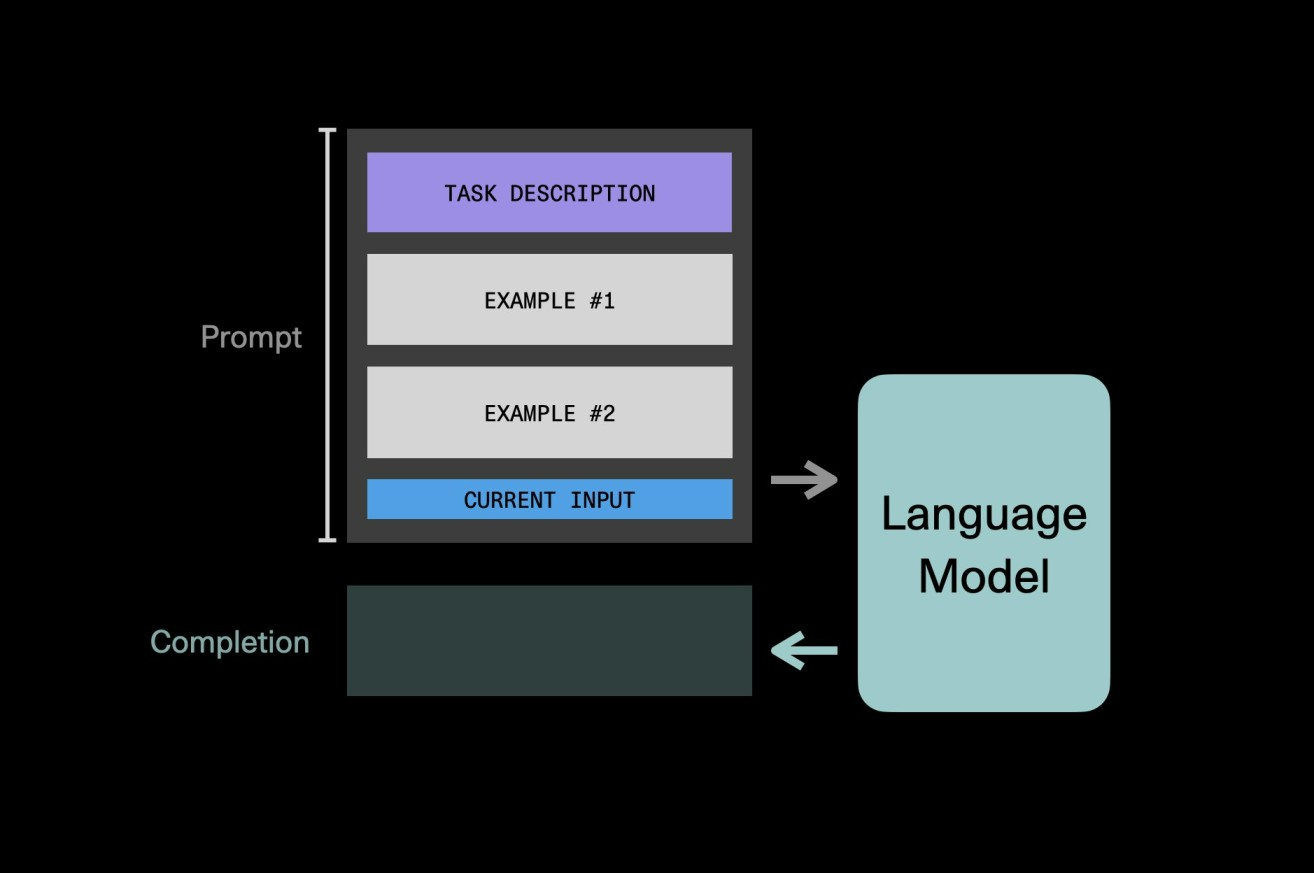

## Different Types of Memory :
1. **ConversationBufferMemory:** simply just the history of the previous text (doesn't make any special text processing; applies some intro and specifies if the text was said by the user or by the AI).
2. **ConversationBufferWindowMemory:** similar to the previous one, but it allows you to specify how many previous *input-output* conversations you want to remember.
3. **ConversationSummaryMemory:** This uses another (or the same) LLM to make a summary of the conversation history in order to make it less memory-intensive.
4. **ConversationTokenBufferMemory:** Similar to *ConversationSummaryMemory*, but it also enables you to specify the max number of tokens, so that you don't send too many tokens to the LLM (making it more cost-friendly).

Keep in mind that, with *ConversationBufferWindowMemory* and *ConversationTokenBufferMemory*, specifying the number of *input-output*'s or the number of tokens can be hard to determine.

Let's dive into their implementation differences with code!

In [11]:
from langchain_openai import ChatOpenAI
from langchain.chains import ConversationChain
from langchain.chains.conversation.memory import (ConversationBufferMemory, 
                                                  ConversationSummaryMemory, 
                                                  ConversationBufferWindowMemory
                                                  )

import tiktoken  # Developed by OpenAI (for token count, text processing, and OpenAI's API cost-estimation)
from langchain.memory import ConversationTokenBufferMemory
from dotenv import load_dotenv
load_dotenv()

True

In [24]:
llm = ChatOpenAI(
    temperature=0.,
    model_name='gpt-3.5-turbo-0125'  #'text-davinci-003' - This model has been depreciated
)

## Different Types Of Memories

### 1. ConversationBufferMemory

**Pros of ConversationBufferMemory:**
1. **Complete conversation history:** It retains the entire conversation history, ensuring comprehensive context for the chatbot.
2. **Accurate references:** By storing conversation excerpts in their original form, it enables precise referencing to past interactions, enhancing accuracy.
3. **Contextual understanding:** The preserved raw form of the conversation helps the chatbot maintain a deep understanding of the ongoing dialogue.
4. **Enhanced responses:** With access to the complete conversation history, the chatbot can generate more relevant and coherent responses.

**Cons of ConversationBufferMemory:**
1. **Increased memory usage:** Storing the entire conversation history consumes memory resources, potentially leading to memory constraints.
2. **Potential performance impact:** Large conversation buffers may slow down processing and response times, affecting the overall system performance.
3. **Limited scalability:** As the conversation grows, the memory requirements and processing load may become impractical for extremely long conversations.
4. **Privacy concerns:** Storing the entire conversation history raises privacy considerations, as sensitive or personal information may be retained in the buffer.

In [25]:
# Encapsulation of LLM to allow for the memory
from langchain.chains import LLMChain

conversation = ConversationChain(
    llm=llm,
    verbose=True,
    memory=ConversationBufferMemory()
)

In [26]:
# Prompt template that is being sent to the LLM by using this ConversationChain
print(conversation.prompt.template)

The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
{history}
Human: {input}
AI:


In [27]:
conversation.predict(input="Good morning AI!")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Good morning AI!
AI:

> Finished chain.


'Good morning! How are you today?'

In [28]:
conversation("My name is Bruno!")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Good morning AI!
AI: Good morning! How are you today?
Human: My name is Bruno!
AI:

> Finished chain.


{'input': 'My name is Bruno!',
 'history': 'Human: Good morning AI!\nAI: Good morning! How are you today?',
 'response': 'Nice to meet you, Bruno! How can I assist you today?'}

In [29]:
conversation.predict(input="I stay in Nijmegen, the Netherlands")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Good morning AI!
AI: Good morning! How are you today?
Human: My name is Bruno!
AI: Nice to meet you, Bruno! How can I assist you today?
Human: I stay in Nijmegen, the Netherlands
AI:

> Finished chain.


'Nijmegen is a beautiful city located in the eastern part of the Netherlands, near the German border. It is known for its rich history, beautiful architecture, and vibrant cultural scene. How can I help you with information about Nijmegen?'

In [30]:
# Check the memory
print(conversation.memory.buffer)

Human: Good morning AI!
AI: Good morning! How are you today?
Human: My name is Bruno!
AI: Nice to meet you, Bruno! How can I assist you today?
Human: I stay in Nijmegen, the Netherlands
AI: Nijmegen is a beautiful city located in the eastern part of the Netherlands, near the German border. It is known for its rich history, beautiful architecture, and vibrant cultural scene. How can I help you with information about Nijmegen?


### 2. ConversationBufferWindowMemory

**Pros of ConversationBufferWindowMemory:**
1. **Efficient memory utilization:** It maintains a limited memory space by only retaining the most recent interactions, optimizing memory usage
2. **Reduced token count:** Dropping the oldest interactions helps to keep the token count low, preventing potential token limitations.
3. **Unmodified context retention:** The latest parts of the conversation are preserved in their original form, ensuring accurate references and contextual understanding.
4. **Up-to-date conversations:** By focusing on recent interactions, it allows the chatbot to stay current and provide more relevant responses.
    
**Cons of ConversationBufferWindowMemory:**
1. **Limited historical context:** Since older interactions are intentionally dropped, the chatbot loses access to the complete conversation history, potentially impacting long-term context and accuracy.
2. **Loss of older information:** Valuable insights or details from earlier interactions are not retained, limiting the chatbot's ability to refer back to past conversations.
3. **Reduced depth of understanding:** Without the full conversation history, the chatbot may have a shallower understanding of the user's context and needs.
4. **Potential loss of context relevance:** Important information or context from older interactions may be disregarded, affecting the chatbot's ability to provide comprehensive responses in certain scenarios.

In [35]:
conversation = ConversationChain(
    llm=llm,
    verbose=True,
    memory=ConversationBufferWindowMemory(k=3)
)

In [36]:
# Prompt template that is being sent to the LLM by using this ConversationChain
print(conversation.prompt.template)

The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
{history}
Human: {input}
AI:


In [37]:
conversation.predict(input="Good morning AI!")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Good morning AI!
AI:

> Finished chain.


'Good morning! How are you today?'

In [38]:
conversation.predict(input="My Name is Bruno")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Good morning AI!
AI: Good morning! How are you today?
Human: My Name is Bruno
AI:

> Finished chain.


'Nice to meet you, Bruno! How can I assist you today?'

In [39]:
conversation.predict(input="I stay in hyderabad, India")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Good morning AI!
AI: Good morning! How are you today?
Human: My Name is Bruno
AI: Nice to meet you, Bruno! How can I assist you today?
Human: I stay in hyderabad, India
AI:

> Finished chain.


"That's great to know, Bruno! Hyderabad is a beautiful city known for its rich history and delicious cuisine. How can I help you with information about Hyderabad or anything else today?"

<font color="blue">
Our LLM with ConversationBufferWindowMemory has a special ability to remember past conversations. 
    <br><br>
<b>It stores and saves the earlier interactions based on our choice of K which simply means the number of past conversions basically a count, allowing it to recall and use that information to make better responses. It ensures that the chatbot can keep track of the conversation history for a more coherent experience.   <font>

In [40]:
# The memory from this chain
print(conversation.memory.buffer)

Human: Good morning AI!
AI: Good morning! How are you today?
Human: My Name is Bruno
AI: Nice to meet you, Bruno! How can I assist you today?
Human: I stay in hyderabad, India
AI: That's great to know, Bruno! Hyderabad is a beautiful city known for its rich history and delicious cuisine. How can I help you with information about Hyderabad or anything else today?


### 3. ConversationSummaryMemory

**Pros of ConversationSummaryMemory:**
1. **Efficient memory management:** It keeps the conversation history in a summarized form, reducing the memory load.
2. **Improved processing:** By condensing the conversation snippets, it makes it easier for the language model to process and generate responses.
3. **Avoiding maxing out limitations:** It helps prevent exceeding the token count limit, ensuring the prompt remains within the processing capacity of the model.
4. **Retains important information:** The summary captures the essential aspects of previous interactions, allowing for relevant context to be maintained.

**Cons of ConversationSummaryMemory:**
1. **Potential loss of detail:** Since the conversation is summarized, some specific details or nuances from earlier interactions might be omitted.
2. **Reliance on summarization quality:** The accuracy and effectiveness of the summarization process depend on the language model's capability, which might introduce potential errors or misinterpretations.
3. **Limited historical context:** Due to summarization, the model's access to the complete conversation history may be limited, potentially impacting the depth of understanding.
4. **Reduced granularity:** The summarized form may lack the fine-grained information present in the original conversation, potentially affecting the accuracy of responses in certain scenarios.

In [41]:
conversation = ConversationChain(
    llm=llm,
    verbose=True,
    memory=ConversationSummaryMemory(llm=llm)
)

In [42]:
# Prompt template that is being sent to the LLM by using this ConversationChain
print(conversation.prompt.template)

The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
{history}
Human: {input}
AI:


In [43]:
# Prompt template that is being sent to the LLM by using this ConversationChain
print(conversation.memory.prompt.template)

Progressively summarize the lines of conversation provided, adding onto the previous summary returning a new summary.

EXAMPLE
Current summary:
The human asks what the AI thinks of artificial intelligence. The AI thinks artificial intelligence is a force for good.

New lines of conversation:
Human: Why do you think artificial intelligence is a force for good?
AI: Because artificial intelligence will help humans reach their full potential.

New summary:
The human asks what the AI thinks of artificial intelligence. The AI thinks artificial intelligence is a force for good because it will help humans reach their full potential.
END OF EXAMPLE

Current summary:
{summary}

New lines of conversation:
{new_lines}

New summary:


In [44]:
conversation.predict(input="Good morning AI!")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Good morning AI!
AI:

> Finished chain.


'Good morning! How are you today?'

In [45]:
conversation.predict(input="My Name is Bruno")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
The human greets the AI with a "Good morning." The AI responds with a "Good morning" and asks how the human is feeling today.
Human: My Name is Bruno
AI:

> Finished chain.


'Nice to meet you, Bruno! How are you feeling today?'

In [46]:
conversation.predict(input="I stay in Nijmegen, Netherlands")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
The human greets the AI with a "Good morning." The AI responds with a "Good morning" and asks how the human is feeling today. The human introduces themselves as Bruno and the AI responds by saying "Nice to meet you, Bruno! How are you feeling today?"
Human: I stay in Nijmegen, Netherlands
AI:

> Finished chain.


'Nijmegen is a beautiful city in the Netherlands, known for its rich history and vibrant culture. How do you like living there, Bruno?'

In [47]:
# Memory buffer
print(conversation.memory.buffer)

The human greets the AI with a "Good morning." The AI responds with a "Good morning" and asks how the human is feeling today. The human introduces themselves as Bruno and the AI responds by saying "Nice to meet you, Bruno! How are you feeling today?" Bruno mentions he stays in Nijmegen, Netherlands. The AI responds by acknowledging Nijmegen as a beautiful city known for its rich history and vibrant culture, asking Bruno how he likes living there.


### 4. ConversationTokenBufferMemory

**Pros of ConversationTokenBufferMemory:**
1. **Efficient memory management:** By using token length instead of the number of interactions, the memory system optimizes memory usage and prevents excessive memory consumption.
2. **Flexible buffer size:** The system adapts to conversations of varying lengths, ensuring that the buffer remains manageable and scalable.
3. **Accurate threshold determination:** Flushing interactions based on token count provides a more precise measure of memory usage, resulting in a better balance between memory efficiency and retaining relevant context.
4. **Improved system performance:** With efficient memory utilization, the overall performance of the system, including response times and processing speed, can be enhanced.
    
**Cons of ConversationTokenBufferMemory:**
1. **Potential loss of context:** Flushing interactions based on token length may result in the removal of earlier interactions that could contain important context or information, potentially affecting the accuracy of responses.
2. **Complexity in threshold setting:** Determining the appropriate token count threshold for flushing interactions may require careful consideration and experimentation to find the optimal balance between memory usage and context retention.
3. **Difficulty in long-term context retention:** Due to the dynamic nature of token-based flushing, retaining long-term context in the conversation may pose challenges as older interactions are more likely to be removed from the buffer.
4. **Impact on response quality:** In situations where high-context conversations are required, the token-based flushing approach may lead to a reduction in the depth of understanding and the quality of responses.

In [48]:
conversation = ConversationChain(
    llm=llm,
    verbose=True,
    memory=ConversationTokenBufferMemory(llm=llm, max_token_limit=60),
)

In [49]:
# Prompt template that is being sent to the LLM by using this ConversationChain
print(conversation.prompt.template)

The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
{history}
Human: {input}
AI:


In [50]:
conversation.predict(input="Good morning AI!")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Good morning AI!
AI:

> Finished chain.


'Good morning! How are you today?'

In [51]:
conversation.predict(input="My Name is Bruno")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Good morning AI!
AI: Good morning! How are you today?
Human: My Name is Bruno
AI:

> Finished chain.


'Nice to meet you, Bruno! How can I assist you today?'

In [52]:
conversation.predict(input="I stay in Nijmegen, the Netherlands")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Good morning AI!
AI: Good morning! How are you today?
Human: My Name is Bruno
AI: Nice to meet you, Bruno! How can I assist you today?
Human: I stay in Nijmegen, the Netherlands
AI:

> Finished chain.


'Nijmegen is a beautiful city located in the eastern part of the Netherlands, near the German border. It is known for its rich history, beautiful architecture, and vibrant cultural scene. How can I help you with information about Nijmegen?'

In [53]:
# The memory buffer
print(conversation.memory.buffer)

AI: Nijmegen is a beautiful city located in the eastern part of the Netherlands, near the German border. It is known for its rich history, beautiful architecture, and vibrant cultural scene. How can I help you with information about Nijmegen?
